In [1]:
import pandas as pd
import gzip
import json
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('/kaggle/input/amazonsentimentanalysisreview/combined_2.csv')

/tmp/ipykernel_35/4256646663.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/amazonsentimentanalysisreview/combined_2.csv')


# Basic Preprocessing and EDA steps

In [3]:
df = df.sample(frac=0.15)

In [4]:
# Make sure to train gridsearchcv on sparse data

In [4]:
df.duplicated().sum()

1499

In [5]:
df = df.drop_duplicates()

In [6]:
df1 = df.drop(['reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'image', 'vote', 'unixReviewTime'], axis=1)
df1

,overall,verified,reviewText,summary
371585,5.0,True,Have ordered and re-ordered many times. Fanta...,Fantastic value.
418921,4.0,True,I am using these needles and am not experienci...,Circular Needles from StitchBerry
203278,1.0,True,I've experienced the same problems as the othe...,then the horrible cracking/distortion noise be...
668851,5.0,True,This is an excellent set of crochet hooks for ...,Excellent hooks at a bargain price.... nice se...
554649,4.0,True,arrived fast and complete.,Four Stars
...,...,...,...,...
145525,5.0,False,"For the $300 price tag, I honestly felt like I...","Make the switch! This is an amazing package, a..."
513452,5.0,True,Wonderful and cheaper than the store!,Wonderful clay
648084,5.0,True,These are really beautiful but I assumed they ...,Five Stars
108688,5.0,True,perfect loved it! worth every penny,Five Stars


In [7]:
print(df1['reviewText'].dtype)


object


In [8]:
df1['verified'].value_counts()

verified
True     101469
False      9443
Name: count, dtype: int64

In [9]:
df2 = df1[df['verified'] == True]
df2

,overall,verified,reviewText,summary
371585,5.0,True,Have ordered and re-ordered many times. Fanta...,Fantastic value.
418921,4.0,True,I am using these needles and am not experienci...,Circular Needles from StitchBerry
203278,1.0,True,I've experienced the same problems as the othe...,then the horrible cracking/distortion noise be...
668851,5.0,True,This is an excellent set of crochet hooks for ...,Excellent hooks at a bargain price.... nice se...
554649,4.0,True,arrived fast and complete.,Four Stars
...,...,...,...,...
456598,5.0,True,Absolutely beautiful. Perfect for my scrapboo...,Absolutely beautiful. Perfect for my scrapbook...
513452,5.0,True,Wonderful and cheaper than the store!,Wonderful clay
648084,5.0,True,These are really beautiful but I assumed they ...,Five Stars
108688,5.0,True,perfect loved it! worth every penny,Five Stars


In [10]:
df2 = df2[df2['overall'] >= 0]

In [11]:
mapping = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}
df3 = df2
df3['overall'] = df3['overall'].map(mapping)
df3

,overall,verified,reviewText,summary
371585,2,True,Have ordered and re-ordered many times. Fanta...,Fantastic value.
418921,2,True,I am using these needles and am not experienci...,Circular Needles from StitchBerry
203278,0,True,I've experienced the same problems as the othe...,then the horrible cracking/distortion noise be...
668851,2,True,This is an excellent set of crochet hooks for ...,Excellent hooks at a bargain price.... nice se...
554649,2,True,arrived fast and complete.,Four Stars
...,...,...,...,...
456598,2,True,Absolutely beautiful. Perfect for my scrapboo...,Absolutely beautiful. Perfect for my scrapbook...
513452,2,True,Wonderful and cheaper than the store!,Wonderful clay
648084,2,True,These are really beautiful but I assumed they ...,Five Stars
108688,2,True,perfect loved it! worth every penny,Five Stars


In [12]:
df3 = df3.dropna(subset=['reviewText', 'summary'])
df3

,overall,verified,reviewText,summary
371585,2,True,Have ordered and re-ordered many times. Fanta...,Fantastic value.
418921,2,True,I am using these needles and am not experienci...,Circular Needles from StitchBerry
203278,0,True,I've experienced the same problems as the othe...,then the horrible cracking/distortion noise be...
668851,2,True,This is an excellent set of crochet hooks for ...,Excellent hooks at a bargain price.... nice se...
554649,2,True,arrived fast and complete.,Four Stars
...,...,...,...,...
456598,2,True,Absolutely beautiful. Perfect for my scrapboo...,Absolutely beautiful. Perfect for my scrapbook...
513452,2,True,Wonderful and cheaper than the store!,Wonderful clay
648084,2,True,These are really beautiful but I assumed they ...,Five Stars
108688,2,True,perfect loved it! worth every penny,Five Stars


In [13]:
df3.loc[:, 'reviewTextSummary'] = df3['reviewText'] + " " + df3['summary']

/tmp/ipykernel_35/3856171434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, 'reviewTextSummary'] = df3['reviewText'] + " " + df3['summary']


In [14]:
df3 = df3.drop(['reviewText', 'summary'], axis=1)
df3

,overall,verified,reviewTextSummary
371585,2,True,Have ordered and re-ordered many times. Fanta...
418921,2,True,I am using these needles and am not experienci...
203278,0,True,I've experienced the same problems as the othe...
668851,2,True,This is an excellent set of crochet hooks for ...
554649,2,True,arrived fast and complete. Four Stars
...,...,...,...
456598,2,True,Absolutely beautiful. Perfect for my scrapboo...
513452,2,True,Wonderful and cheaper than the store! Wonderfu...
648084,2,True,These are really beautiful but I assumed they ...
108688,2,True,perfect loved it! worth every penny Five Stars


In [15]:
df3['overall'].value_counts()

overall
2    89725
1     6117
0     5534
Name: count, dtype: int64

In [16]:
missing_values = df3['reviewTextSummary'].isnull().sum()
missing_values

0

### Training multiple Tests by splitting data after combining ReviewText and Summary

In [17]:
y = df3['overall']

X_train_prep, X_tmp_prep, y_train_prep, y_tmp_prep = train_test_split(df3['reviewTextSummary'], y, test_size=0.3, random_state=42)
X_test_prep, X_val_prep, y_test_prep, y_val_prep = train_test_split(X_tmp_prep, y_tmp_prep, test_size=0.5, random_state=42)

In [25]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_prep)
sample_weights

array([0.37684738, 0.37684738, 0.37684738, ..., 0.37684738, 0.37684738,
       0.37684738])

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

In [19]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [20]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [21]:
# Preprocessing, stemming, and lemmatization methods
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
stop_word_group = stopwords.words('english')

lematizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text_lem(textblob):
    textblob = re.sub(r'\d', '', textblob, re.UNICODE)
    textblob = re.sub(r'[^\w\s]', '', textblob, re.UNICODE)
    textblob = textblob.lower()
    textblob = [lematizer.lemmatize(token) for token in textblob.split(" ")]
    textblob = [word for word in textblob if not word in stop_word_group] # removing any stopwords 
    textblob = " ".join(textblob)
    return textblob

def preprocess_text_stem(textblob):
    textblob = re.sub(r'\d', '', textblob, re.UNICODE)
    textblob = re.sub(r'[^\w\s]', '', textblob, re.UNICODE)
    textblob = textblob.lower()
    textblob = [stemmer.stem(token) for token in textblob.split(" ")]
    textblob = [word for word in textblob if not word in stop_word_group] # removing any stopwords 
    textblob = " ".join(textblob)
    return textblob

def preprocess_text_none(textblob):
    textblob = re.sub(r'\d', '', textblob, re.UNICODE)
    textblob = re.sub(r'[^\w\s]', '', textblob, re.UNICODE)
    textblob = textblob.lower()
    textblob = [word for word in textblob if not word in stop_word_group] # removing any stopwords 
    textblob = " ".join(textblob)
    return textblob

# def preprocess_text(textblob):
#     try:
#         textblob = re.sub(r'\d', '', textblob, re.UNICODE)
#         textblob = re.sub(r'[^\w\s]', '', textblob, re.UNICODE)
#         textblob = textblob.lower()
#         textblob = [lematizer.lemmatize(token) for token in textblob.split(" ")]
#         textblob = [word for word in textblob if not word in stop_word_group] # removing any stopwords 
#         textblob = " ".join(textblob)
#     except:
#         print(textblob)
#         return textblob
#     return textblob


X_train_lemmer = X_train_prep.apply(lambda x: preprocess_text_lem(x))
X_val_lemmer = X_val_prep.apply(lambda x: preprocess_text_lem(x))
X_test_lemmer = X_test_prep.apply(lambda x: preprocess_text_lem(x))

X_train_stemmer = X_train_prep.apply(lambda x: preprocess_text_stem(x))
X_val_stemmer = X_val_prep.apply(lambda x: preprocess_text_stem(x))
X_test_stemmer = X_test_prep.apply(lambda x: preprocess_text_lem(x))

X_train_none = X_train_prep.apply(lambda x: preprocess_text_stem(x))
X_val_none = X_val_prep.apply(lambda x: preprocess_text_stem(x))
X_test_none = X_test_prep.apply(lambda x: preprocess_text_lem(x))

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Vectorization using TfIDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
tfTool = TfidfVectorizer()
X_train_lemmer = tfTool.fit_transform(X_train_lemmer)
X_val_lemmer = tfTool.transform(X_val_lemmer)
X_test_lemmer = tfTool.transform(X_test_lemmer)

tfTool = TfidfVectorizer()
X_train_stemmer = tfTool.fit_transform(X_train_stemmer)
X_val_stemmer = tfTool.transform(X_val_stemmer)
X_test_stemmer = tfTool.transform(X_test_stemmer)


tfTool = TfidfVectorizer()
X_train_none = tfTool.fit_transform(X_train_none)
X_val_none = tfTool.transform(X_val_none)
X_test_none = tfTool.transform(X_test_none)

In [23]:
tfTool = TfidfVectorizer()
X_train_prep = tfTool.fit_transform(X_train_prep)
X_val_prep = tfTool.transform(X_val_prep)
X_test_prep = tfTool.transform(X_test_prep)

# Training model using various cases for Sparse Data Using unpreprocessed, preprocessed, stemming, and lemmatization

In [26]:
# base model of original train and test set both with and without sample_weights
base_model_orig_sparse_1 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_orig_sparse_1.fit(X_train_prep, y_train_prep)

y_base_pred_orig1 = base_model_orig_sparse_1.predict(X_test_prep)
y_base_pred_orig_rec_1 = base_model_orig_sparse_1.predict_proba(X_test_prep)

print(classification_report(y_test_prep, y_base_pred_orig1))

print("--------------------------------------------------------------------")

# base model of original train and test using sample_weights
base_model_orig_sparse_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_orig_sparse_2.fit(X_train_prep, y_train_prep, sample_weight=sample_weights)

y_base_pred_orig2 = base_model_orig_sparse_2.predict(X_test_prep)
y_base_pred_orig_rec_2 = base_model_orig_sparse_2.predict_proba(X_test_prep)

print(classification_report(y_test_prep, y_base_pred_orig2))

              precision    recall  f1-score   support

           0       0.83      0.04      0.08       823
           1       0.89      0.23      0.37       940
           2       0.90      1.00      0.95     13443

    accuracy                           0.90     15206
   macro avg       0.87      0.42      0.47     15206
weighted avg       0.90      0.90      0.86     15206

--------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.07      0.30      0.12       823
           1       0.16      0.26      0.20       940
           2       0.90      0.69      0.78     13443

    accuracy                           0.64     15206
   macro avg       0.38      0.42      0.36     15206
weighted avg       0.81      0.64      0.71     15206



In [28]:
# tuned model of original train and test set both with and without sample_weights
tuned_model_orig_sparse_1 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_orig_sparse_1.fit(X_train_prep, y_train_prep)

y_tuned_pred_orig1 = tuned_model_orig_sparse_1.predict(X_test_prep)
y_tuned_pred_orig_rec_1 = tuned_model_orig_sparse_1.predict_proba(X_test_prep)

print(classification_report(y_test_prep, y_tuned_pred_orig1))

print("--------------------------------------------------------------------")

# base model of original train and test using sample_weights
tuned_model_orig_sparse_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_orig_sparse_2.fit(X_train_prep, y_train_prep, sample_weight=sample_weights)

y_tuned_pred_orig2 = tuned_model_orig_sparse_2.predict(X_test_prep)
y_tuned_pred_orig_rec_2 = tuned_model_orig_sparse_2.predict_proba(X_test_prep)

print(classification_report(y_test_prep, y_tuned_pred_orig2))

              precision    recall  f1-score   support

           0       0.12      0.36      0.17       823
           1       1.00      0.03      0.06       940
           2       0.90      0.85      0.88     13443

    accuracy                           0.77     15206
   macro avg       0.67      0.41      0.37     15206
weighted avg       0.87      0.77      0.79     15206

--------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.04      0.45      0.08       823
           1       0.09      0.41      0.15       940
           2       0.92      0.15      0.26     13443

    accuracy                           0.19     15206
   macro avg       0.35      0.34      0.16     15206
weighted avg       0.82      0.19      0.25     15206



In [27]:
# base models for Lemmatization
base_model_lemm_sparse_1 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_lemm_sparse_1.fit(X_train_lemmer, y_train_prep)

y_base_pred_lem1 = base_model_lemm_sparse_1.predict(X_test_lemmer)
y_base_pred_lem_rec_1 = base_model_lemm_sparse_1.predict_proba(X_test_lemmer)

print(classification_report(y_test_prep, y_base_pred_lem1))
print("-----------------------------------------------------------------------------------")
# base model for stemming
base_model_stem_sparse_1 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_stem_sparse_1.fit(X_train_stemmer, y_train_prep)

y_base_pred_stem_1 = base_model_stem_sparse_1.predict(X_test_stemmer)
y_base_pred_stem_rec_1 = base_model_stem_sparse_1.predict_proba(X_test_stemmer)

print(classification_report(y_test_prep, y_base_pred_stem_1))
print("-------------------------------------------------------------------------------------")
# base model for none
base_model_none_sparse_1 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_none_sparse_1.fit(X_train_none, y_train_prep)

y_base_pred_none_1 = base_model_none_sparse_1.predict(X_test_none)
y_base_pred_none_rec_1 = base_model_none_sparse_1.predict_proba(X_test_none)

print(classification_report(y_test_prep, y_base_pred_none_1))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       898
           1       0.00      0.00      0.00       930
           2       0.88      1.00      0.94     13379

    accuracy                           0.88     15207
   macro avg       0.29      0.33      0.31     15207
weighted avg       0.77      0.88      0.82     15207

-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.03      0.10      0.04       898
           1       0.00      0.01      0.00       930
           2       0.80      0.47      0.59     13379

    accuracy                           0.42     15207
   macro avg       0.28      0.20      0.21     15207
weighted avg       0.70      0.42      0.52     15207

-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0 

array([0.37730562, 0.37730562, 0.37730562, ..., 0.37730562, 0.37730562,
       0.37730562])

In [31]:
# sparse data version using sample_weights

# base models for Lemmatization
base_model_lemm_sparse_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_lemm_sparse_2.fit(X_train_lemmer, y_train_prep, sample_weight=sample_weights)

y_base_pred_lem2 = base_model_lemm_sparse_2.predict(X_test_lemmer)
y_base_pred_lem_rec_2 = base_model_lemm_sparse_2.predict_proba(X_test_lemmer)

print(classification_report(y_test_prep, y_base_pred_lem2))
print("-----------------------------------------------------------------------------------")
# base model for stemming
base_model_stem_sparse_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_stem_sparse_2.fit(X_train_stemmer, y_train_prep, sample_weight=sample_weights)

y_base_pred_stem_2 = base_model_stem_sparse_2.predict(X_test_stemmer)
y_base_pred_stem_rec_2 = base_model_stem_sparse_2.predict_proba(X_test_stemmer)

print(classification_report(y_test_prep, y_base_pred_stem_2))
print("-------------------------------------------------------------------------------------")
# base model for none
base_model_none_sparse_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
base_model_none_sparse_2.fit(X_train_none, y_train_prep, sample_weight=sample_weights)

y_base_pred_none_2 = base_model_none_sparse_2.predict(X_test_none)
y_base_pred_none_rec_2 = base_model_none_sparse_2.predict_proba(X_test_none)

print(classification_report(y_test_prep, y_base_pred_none_2))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.06      0.04      0.05       898
           1       0.00      0.00      0.00       930
           2       0.88      0.96      0.92     13379

    accuracy                           0.85     15207
   macro avg       0.31      0.33      0.32     15207
weighted avg       0.78      0.85      0.81     15207

-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       898
           1       0.07      0.98      0.13       930
           2       0.99      0.07      0.13     13379

    accuracy                           0.12     15207
   macro avg       0.36      0.35      0.09     15207
weighted avg       0.88      0.12      0.13     15207

-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0 

In [33]:
# tuned model using sparse data

tuned_model_lemm_sparse_1 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_lemm_sparse_1.fit(X_train_lemmer, y_train_prep)

y_tune_pred_lem_1 = tuned_model_lemm_sparse_1.predict(X_test_lemmer)
y_tune_pred_lem_rec_1 = tuned_model_lemm_sparse_1.predict_proba(X_test_lemmer)

print(classification_report(y_test_prep, y_tune_pred_lem_1))
print("-----------------------------------------------------------------------------------")
# base model for stemming
tuned_model_stem_sparse_1 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_stem_sparse_1.fit(X_train_stemmer, y_train_prep)

y_tuned_pred_stem_1 = tuned_model_stem_sparse_1.predict(X_test_stemmer)
y_tuned_pred_stem_rec_1 = tuned_model_stem_sparse_1.predict_proba(X_test_stemmer)

print(classification_report(y_test_prep, y_base_pred_stem_1))
print("-------------------------------------------------------------------------------------")
# base model for none
tuned_model_none_sparse_1 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_none_sparse_1.fit(X_train_none, y_train_prep)

y_tuned_pred_none_1 = tuned_model_none_sparse_1.predict(X_test_none)
y_tuned_pred_none_rec_1 = tuned_model_none_sparse_1.predict_proba(X_test_none)

print(classification_report(y_test_prep, y_tuned_pred_none_1))

              precision    recall  f1-score   support

           0       0.87      0.07      0.14       898
           1       0.97      0.24      0.38       930
           2       0.90      1.00      0.95     13379

    accuracy                           0.90     15207
   macro avg       0.91      0.44      0.49     15207
weighted avg       0.90      0.90      0.86     15207

-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.03      0.10      0.04       898
           1       0.00      0.01      0.00       930
           2       0.80      0.47      0.59     13379

    accuracy                           0.42     15207
   macro avg       0.28      0.20      0.21     15207
weighted avg       0.70      0.42      0.52     15207

-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0 

In [34]:
# tuned models on sparse data using sample weights
tuned_model_lemm_sparse_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_lemm_sparse_2.fit(X_train_lemmer, y_train_prep, sample_weight=sample_weights)

y_tune_pred_lem_2 = tuned_model_lemm_sparse_2.predict(X_test_lemmer)
y_tune_pred_lem_rec_2 = tuned_model_lemm_sparse_2.predict_proba(X_test_lemmer)

print(classification_report(y_test_prep, y_tune_pred_lem_2))
print("-----------------------------------------------------------------------------------")
# base model for stemming
tuned_model_stem_sparse_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_stem_sparse_2.fit(X_train_stemmer, y_train_prep, sample_weight=sample_weights)

y_tuned_pred_stem_2 = tuned_model_stem_sparse_2.predict(X_test_stemmer)
y_tuned_pred_stem_rec_2 = tuned_model_stem_sparse_2.predict_proba(X_test_stemmer)

print(classification_report(y_test_prep, y_base_pred_stem_2))
print("-------------------------------------------------------------------------------------")
# base model for none
tuned_model_none_sparse_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
tuned_model_none_sparse_2.fit(X_train_none, y_train_prep, sample_weight=sample_weights)

y_tuned_pred_none_2 = tuned_model_none_sparse_2.predict(X_test_none)
y_tuned_pred_none_rec_2 = tuned_model_none_sparse_2.predict_proba(X_test_none)

print(classification_report(y_test_prep, y_tuned_pred_none_2))

              precision    recall  f1-score   support

           0       0.11      0.48      0.18       898
           1       0.13      0.42      0.20       930
           2       0.95      0.58      0.72     13379

    accuracy                           0.57     15207
   macro avg       0.40      0.49      0.37     15207
weighted avg       0.85      0.57      0.66     15207

-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       898
           1       0.07      0.98      0.13       930
           2       0.99      0.07      0.13     13379

    accuracy                           0.12     15207
   macro avg       0.36      0.35      0.09     15207
weighted avg       0.88      0.12      0.13     15207

-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Using dense data with train and test set split after combining summary with reviewText

In [ ]:
from scipy.sparse import csr_matrix
# Lemmatization
X_train_dense_lemm = csr_matrix(X_train_lemmer).todense()
X_val_dense_lemm = csr_matrix(X_val_lemmer).todense()
X_test_dense_lemm = csr_matrix(X_test_lemmer).todense()

X_train_dense_stem = csr_matrix(X_train_stemmer).todense()
X_val_dense_stem = csr_matrix(X_val_stemmer).todense()
X_test_dense_stem = csr_matrix(X_test_stemmer).todense()

X_train_dense_none = csr_matrix(X_train_none).todense()
X_val_dense_none = csr_matrix(X_val_none).todense()
X_test_dense_none = csr_matrix(X_test_none).todense()



In [30]:
from scipy.sparse import csr_matrix
X_train_dense_prep = csr_matrix(X_train_prep).todense()
X_val_dense_prep = csr_matrix(X_val_prep).todense()
X_test_dense_prep = csr_matrix(X_test_prep).todense()

In [32]:
# based model on the weighted data of original train test set wirh and without sample_weight
# base model for original
early_mod_base_weight_orig = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_orig.fit(X_train_dense_prep, y_train_prep)

early_orig_base_weight_pred = early_mod_base_weight_orig.predict(X_test_dense_prep)

print(classification_report(y_test_prep, early_orig_base_weight_pred))

print("-------------------------------------------------------------------------")

# apply base model for original using sample_weights
early_mod_base_weight_orig_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_orig_2.fit(X_train_dense_prep, y_train_prep, sample_weight=sample_weights)

early_orig_base_weight_pred_2 = early_mod_base_weight_orig_2.predict(X_test_dense_prep)

print(classification_report(y_test_prep, early_orig_base_weight_pred_2))




              precision    recall  f1-score   support

           0       0.80      0.53      0.64       823
           1       0.76      0.37      0.50       940
           2       0.94      0.99      0.96     13443

    accuracy                           0.93     15206
   macro avg       0.83      0.63      0.70     15206
weighted avg       0.92      0.93      0.92     15206

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.75      0.59       823
           1       0.36      0.66      0.46       940
           2       0.98      0.89      0.93     13443

    accuracy                           0.87     15206
   macro avg       0.61      0.77      0.66     15206
weighted avg       0.92      0.87      0.89     15206



In [35]:
# saving best model to pickle file
import pickle
best_model = early_mod_base_weight_orig
with open('/kaggle/working/model_XGBoost.pkl', 'wb') as files:
  pickle.dump(best_model, files)

In [36]:
with open('/kaggle/working/model_XGBoost.pkl', 'rb') as f:
  test_pkl = pickle.load(f)
  
pkl_pred = test_pkl.predict(X_test_dense_prep)

print(classification_report(y_test_prep, pkl_pred))


              precision    recall  f1-score   support

           0       0.80      0.53      0.64       823
           1       0.76      0.37      0.50       940
           2       0.94      0.99      0.96     13443

    accuracy                           0.93     15206
   macro avg       0.83      0.63      0.70     15206
weighted avg       0.92      0.93      0.92     15206



In [45]:
early_orig_base_weight_pred_roc = early_mod_base_weight_orig.predict_proba(X_test_dense_prep)

print("AUC: ", roc_auc_score(y_test_prep, early_orig_base_weight_pred_roc, average = 'macro', multi_class='ovr'))



AUC:  0.9552732120542284


In [52]:

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train_prep)
y_onehot_test = label_binarizer.transform(y_test_prep)
y_onehot_test.shape  # (n_samples, n_classes)

class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), early_orig_base_weight_pred_roc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], early_orig_base_weight_pred_roc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(3):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 3

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")



Micro-averaged One-vs-Rest ROC AUC score:
0.99
Macro-averaged One-vs-Rest ROC AUC score:
0.96


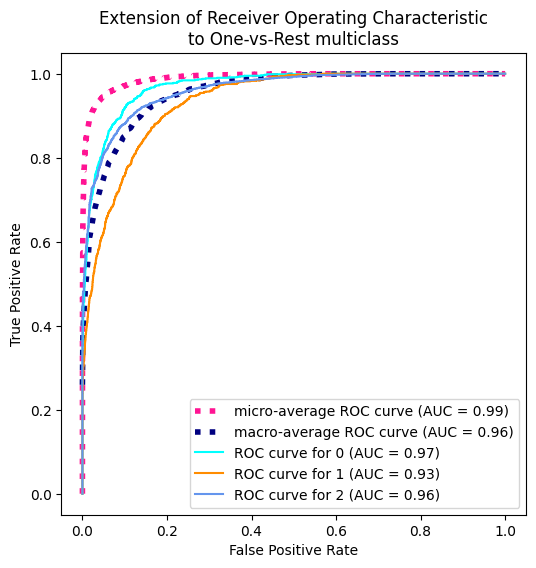

In [54]:
from itertools import cycle
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(6, 6))

target_names = [0, 1, 2]

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        early_orig_base_weight_pred_roc[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

In [33]:
# tuned model using original training and test set with and without sample_weights
early_mod_tuned_weight_orig = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_orig.fit(X_train_dense_prep, y_train_prep)

early_orig_tuned_weight_pred = early_mod_tuned_weight_orig.predict(X_test_dense_prep)

print(classification_report(y_test_prep, early_orig_tuned_weight_pred))

print("-------------------------------------------------------------------------")

# apply tuned model for original using sample_weights
early_mod_tuned_weight_orig_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_orig_2.fit(X_train_dense_prep, y_train_prep, sample_weight=sample_weights)

early_orig_tuned_weight_pred_2 = early_mod_tuned_weight_orig_2.predict(X_test_dense_prep)

print(classification_report(y_test_prep, early_orig_tuned_weight_pred_2))


              precision    recall  f1-score   support

           0       0.79      0.37      0.50       823
           1       0.86      0.29      0.44       940
           2       0.92      0.99      0.96     13443

    accuracy                           0.92     15206
   macro avg       0.86      0.55      0.63     15206
weighted avg       0.91      0.92      0.90     15206

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.26      0.74      0.38       823
           1       0.31      0.64      0.41       940
           2       0.98      0.80      0.88     13443

    accuracy                           0.78     15206
   macro avg       0.52      0.73      0.56     15206
weighted avg       0.90      0.78      0.82     15206



In [26]:
# Base model for dense features

# base model for lemmatization
early_mod_base_weight_lemm = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_lemm.fit(X_train_dense_lemm, y_train_prep)

early_lemm_base_weight_pred = early_mod_base_weight_lemm.predict(X_test_dense_lemm)

print(classification_report(y_test_prep, early_lemm_base_weight_pred))

print("-------------------------------------------------------------------------")

# appl,y base model for stemming on weighted
early_mod_base_weight_stemm = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_stemm.fit(X_train_dense_stem, y_train_prep)

early_stemm_base_weight_pred = early_mod_base_weight_stemm.predict(X_test_dense_stem)

print(classification_report(y_test_prep, early_stemm_base_weight_pred))

print("---------------------------------------------------------------------------------")

early_mod_base_weight_none = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_none.fit(X_train_dense_none, y_train_prep)

early_none_base_weight_pred = early_mod_base_weight_none.predict(X_test_dense_none)

print(classification_report(y_test_prep, early_none_base_weight_pred))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:17:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.79      0.48      0.60       814
           1       0.78      0.36      0.49       901
           2       0.94      0.99      0.96     13489

    accuracy                           0.93     15204
   macro avg       0.84      0.61      0.68     15204
weighted avg       0.92      0.93      0.92     15204

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.31      0.45       814
           1       0.79      0.32      0.45       901
           2       0.92      0.99      0.96     13489

    accuracy                           0.92     15204
   macro avg       0.84      0.54      0.62     15204
weighted avg       0.91      0.92      0.90     15204

---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81    

In [29]:
# Base model for dense features using sample_weights

# base model for lemmatization
early_mod_base_weight_lemm_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_lemm_2.fit(X_train_dense_lemm, y_train_prep, sample_weight=sample_weights)

early_lemm_base_weight_pred_2 = early_mod_base_weight_lemm_2.predict(X_test_dense_lemm)

print(classification_report(y_test_prep, early_lemm_base_weight_pred_2))

print("-------------------------------------------------------------------------")

# apply base model for stemming on weighted
early_mod_base_weight_stemm_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_stemm_2.fit(X_train_dense_stem, y_train_prep, sample_weight=sample_weights)

early_stemm_base_weight_pred_2 = early_mod_base_weight_stemm_2.predict(X_test_dense_stem)

print(classification_report(y_test_prep, early_stemm_base_weight_pred_2))

print("---------------------------------------------------------------------------------")

# apply base model for no changes using sample_weights
early_mod_base_weight_none_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_base_weight_none_2.fit(X_train_dense_none, y_train_prep, sample_weight=sample_weights)

early_none_base_weight_pred_2 = early_mod_base_weight_none_2.predict(X_test_dense_none)

print(classification_report(y_test_prep, early_none_base_weight_pred_2))

              precision    recall  f1-score   support

           0       0.38      0.75      0.50       814
           1       0.32      0.62      0.42       901
           2       0.98      0.86      0.92     13489

    accuracy                           0.84     15204
   macro avg       0.56      0.75      0.61     15204
weighted avg       0.91      0.84      0.87     15204

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.23      0.76      0.35       814
           1       0.23      0.63      0.33       901
           2       0.99      0.73      0.84     13489

    accuracy                           0.73     15204
   macro avg       0.48      0.71      0.51     15204
weighted avg       0.90      0.73      0.79     15204

---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.23    

In [27]:
# tuned models for all weighted cases

# Lemmatiztion tuned model
early_mod_tuned_weight_lemm = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_lemm.fit(X_train_dense_lemm, y_train_prep)

early_lemm_tuned_weight_pred = early_mod_tuned_weight_lemm.predict(X_test_dense_lemm)

print(classification_report(y_test_prep, early_lemm_tuned_weight_pred))

print("-------------------------------------------------------------------------")

# apply base model for stemming on weighted
early_mod_tuned_weight_stemm = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_stemm.fit(X_train_dense_stem, y_train_prep)

early_stemm_tuned_weight_pred = early_mod_tuned_weight_stemm.predict(X_test_dense_stem)

print(classification_report(y_test_prep, early_stemm_tuned_weight_pred))

print("---------------------------------------------------------------------------------")

# apply base model for no changes using sample_weights
early_mod_tuned_weight_none = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_none.fit(X_train_dense_none, y_train_prep)

early_none_tuned_weight_pred = early_mod_tuned_weight_none.predict(X_test_dense_none)

print(classification_report(y_test_prep, early_none_tuned_weight_pred))


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:08:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.86      0.24      0.38       858
           1       0.88      0.25      0.39       910
           2       0.91      1.00      0.95     13438

    accuracy                           0.91     15206
   macro avg       0.88      0.50      0.57     15206
weighted avg       0.91      0.91      0.89     15206

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.21      0.33       858
           1       0.90      0.25      0.39       910
           2       0.91      1.00      0.95     13438

    accuracy                           0.91     15206
   macro avg       0.89      0.48      0.56     15206
weighted avg       0.91      0.91      0.88     15206

---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85    

In [29]:
# tuned model tests on weighted set with sample_weights

# Lemmatiztion tuned model
early_mod_tuned_weight_lemm_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_lemm_2.fit(X_train_dense_lemm, y_train_prep, sample_weight=sample_weights)

early_lemm_tuned_weight_pred_2 = early_mod_tuned_weight_lemm_2.predict(X_test_dense_lemm)

print(classification_report(y_test_prep, early_lemm_tuned_weight_pred_2))

print("-------------------------------------------------------------------------")

# apply base model for stemming on weighted using sample_weights
early_mod_tuned_weight_stemm_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_stemm_2.fit(X_train_dense_stem, y_train_prep, sample_weight=sample_weights)

early_stemm_tuned_weight_pred_2 = early_mod_tuned_weight_stemm_2.predict(X_test_dense_stem)

print(classification_report(y_test_prep, early_stemm_tuned_weight_pred_2))

print("---------------------------------------------------------------------------------")

# apply base model for no changes using sample_weights
early_mod_tuned_weight_none_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
early_mod_tuned_weight_none_2.fit(X_train_dense_none, y_train_prep, sample_weight=sample_weights)

early_none_tuned_weight_pred_2 = early_mod_tuned_weight_none_2.predict(X_test_dense_none)

print(classification_report(y_test_prep, early_none_tuned_weight_pred_2))

              precision    recall  f1-score   support

           0       0.23      0.78      0.35       858
           1       0.29      0.54      0.38       910
           2       0.98      0.77      0.86     13438

    accuracy                           0.76     15206
   macro avg       0.50      0.70      0.53     15206
weighted avg       0.90      0.76      0.81     15206

-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.19      0.78      0.30       858
           1       0.24      0.53      0.33       910
           2       0.98      0.71      0.82     13438

    accuracy                           0.70     15206
   macro avg       0.47      0.67      0.49     15206
weighted avg       0.89      0.70      0.76     15206

---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.19    

In [ ]:
# code below that applied lemmatization on full dataset, does vectorization on the full thing, and then splits into training, test, and validation

# Old code applying lemmatization to full dataset, doing vectorization, and then splitting into train, test, and validation

In [21]:
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('wordnet')
# stop_word_group = stopwords.words('english')

# lematizer = WordNetLemmatizer()

# def preprocess_text(textblob):
#     textblob = re.sub(r'\d', '', textblob, re.UNICODE)
#     textblob = re.sub(r'[^\w\s]', '', textblob, re.UNICODE)
#     textblob = textblob.lower()
#     textblob = [lematizer.lemmatize(token) for token in textblob.split(" ")]
#     textblob = [word for word in textblob if not word in stop_word_group] # removing any stopwords 
#     textblob = " ".join(textblob)
#     return textblob


# df3['reviewTextSummary'] = df3.reviewTextSummary.apply(lambda x: preprocess_text(x))
# df3

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,overall,verified,reviewTextSummary
155877,2,True,guitar kit awesome wa delivered fast good cond...
492074,2,True,love paper pad ha romantic elegant feel love n...
213626,2,True,industry standard fit perfectly blue badge ma...
348441,0,True,wa disappointed lamp black flat black paint ha...
581896,2,True,find result work product plantldyetsycom five...
...,...,...,...
519616,2,True,happy buy five star
99018,2,True,bag rock five star
651511,2,True,work great five star
731024,2,True,love great love different cut took figure get ...


In [22]:
#from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# vvecTool = TfidfVectorizer(max_features=2000)
# data_features = vvecTool.fit_transform(df3['reviewTextSummary'])
# data_features = data_features.toarray()
# print(data_features)

In [24]:
#y = df3['overall']

In [25]:
# from sklearn.model_selection import train_test_split

# #X_train, X_tmp, y_train, y_tmp = train_test_split(data_features, y, test_size=0.2, random_state=42)
# X_train, X_tmp, y_train, y_tmp = train_test_split(df3['reviewTextSummary'], y, test_size=0.3, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)



In [26]:
# vvecTool = TfidfVectorizer()
# vvecTool.fit(df3['reviewTextSummary'])
# X_train = vvecTool.fit_transform(X_train)
# X_val = vvecTool.transform(X_val)
# X_test = vvecTool.transform(X_test)

In [27]:
# from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# sample_weights

array([0.37734448, 0.37734448, 5.47498075, ..., 0.37734448, 0.37734448,
       0.37734448])

# Old Tests using Sparse data

In [28]:
# base model
# base_model_sparse_1 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# base_model_sparse_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [29]:
# y_base_pred = base_model_sparse_1.predict(X_test)
# y_base_pred_roc = base_model_sparse_1.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:32:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [30]:
# print(classification_report(y_test, y_base_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       851
           1       0.06      0.78      0.11       930
           2       0.92      0.20      0.33     13459

    accuracy                           0.22     15240
   macro avg       0.33      0.33      0.15     15240
weighted avg       0.81      0.22      0.30     15240



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# base model using sample_weights
# base_model_sparse_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# base_model_sparse_2.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [32]:
# y_base_pred_2 = base_model_sparse_2.predict(X_test)
# y_base_pred_roc_2 = base_model_sparse_2.predict_proba(X_test)

In [33]:
#print("Area under the curve: ", roc_auc_score(y_test, y_base_pred_2))
# print(classification_report(y_test, y_base_pred_2))

              precision    recall  f1-score   support

           0       0.11      0.92      0.19       851
           1       0.77      0.24      0.36       930
           2       0.98      0.55      0.70     13459

    accuracy                           0.55     15240
   macro avg       0.62      0.57      0.42     15240
weighted avg       0.92      0.55      0.66     15240



In [34]:
# tuned parameters on sparse array
# sparse_tuned_model = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# sparse_tuned_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [35]:
# y_tune_pred = sparse_tuned_model.predict(X_test)
# y_tune_pred_roc = sparse_tuned_model.predict_proba(X_test)

In [36]:
#print("Area under the curve: ", roc_auc_score(y_test, y_tune_pred))
#print(classification_report(y_test, y_tune_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       851
           1       0.98      0.22      0.36       930
           2       0.90      1.00      0.94     13459

    accuracy                           0.90     15240
   macro avg       0.96      0.41      0.44     15240
weighted avg       0.91      0.90      0.86     15240



In [37]:
# train model on sparse data using sample_weights
# sparse_tuned_model_2 = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# sparse_tuned_model_2.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [38]:
# y_tune_pred_2 = sparse_tuned_model_2.predict(X_test)
# y_tune_pred_roc_2 = sparse_tuned_model_2.predict_proba(X_test)

In [39]:
#print(classification_report(y_test, y_tune_pred_2))

              precision    recall  f1-score   support

           0       0.06      0.49      0.11       851
           1       0.18      0.28      0.22       930
           2       0.92      0.49      0.64     13459

    accuracy                           0.48     15240
   macro avg       0.39      0.42      0.33     15240
weighted avg       0.82      0.48      0.59     15240



### Old Tests using Dense data 

In [40]:
# from scipy.sparse import csr_matrix
# X_train_dense = csr_matrix(X_train).todense()
# X_val_dense = csr_matrix(X_val).todense()
# X_test_dense = csr_matrix(X_test).todense()

In [41]:
# base_weighted_model_1 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# base_weighted_model_1.fit(X_train_dense, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [42]:
# y_weighted_base_pred = base_weighted_model_1.predict(X_test_dense)
# y_weighted_base_pred_roc = base_weighted_model_1.predict_proba(X_test_dense)

In [43]:
#print(classification_report(y_test, y_weighted_base_pred))

              precision    recall  f1-score   support

           0       0.84      0.50      0.63       851
           1       0.75      0.33      0.46       930
           2       0.93      0.99      0.96     13459

    accuracy                           0.92     15240
   macro avg       0.84      0.61      0.68     15240
weighted avg       0.92      0.92      0.91     15240



In [44]:
# weighted data with sample_weights
# base_weighted_model_2 = XGBClassifier(objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# base_weighted_model_2.fit(X_train_dense, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [45]:
# y_weighted_base_pred_2 = base_weighted_model_2.predict(X_test_dense)
# y_weighted_base_pred_roc_2 = base_weighted_model_2.predict_proba(X_test_dense)

In [46]:
#print(classification_report(y_test, y_weighted_base_pred_2))

              precision    recall  f1-score   support

           0       0.39      0.79      0.53       851
           1       0.33      0.60      0.42       930
           2       0.98      0.86      0.92     13459

    accuracy                           0.84     15240
   macro avg       0.57      0.75      0.62     15240
weighted avg       0.91      0.84      0.87     15240



In [ ]:
# train model using tuned parameters
# tuned_weighted_model =  XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# tuned_weighted_model.fit(X_train_dense, y_train)

# rename this variable

#y_base_pred_roc_2 = base_model_2.predict_proba(X_test)

In [48]:
#y_weighted_tuned_pred = tuned_weighted_model.predict(X_test_dense)

In [49]:
#print(classification_report(y_test, y_weighted_tuned_pred))

              precision    recall  f1-score   support

           0       0.89      0.28      0.43       851
           1       0.80      0.28      0.42       930
           2       0.91      1.00      0.95     13459

    accuracy                           0.91     15240
   macro avg       0.87      0.52      0.60     15240
weighted avg       0.91      0.91      0.89     15240



In [50]:
# tuned_weighted_model_2 =  XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=200, objective='multi:softmax', random_state=42, tree_method='hist', device='cuda')
# tuned_weighted_model_2.fit(X_train_dense, y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [51]:
#y_weighted_tuned_pred_2 = tuned_weighted_model_2.predict(X_test_dense)


In [52]:
print(classification_report(y_test, y_weighted_tuned_pred_2))

              precision    recall  f1-score   support

           0       0.22      0.83      0.35       851
           1       0.28      0.52      0.37       930
           2       0.98      0.76      0.86     13459

    accuracy                           0.75     15240
   macro avg       0.50      0.70      0.53     15240
weighted avg       0.90      0.75      0.80     15240



# Older version where hyperparameter tuning was first applied

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # from scipy.stats import randint
# # from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier


# #mod = XGBClassifier(objective='multi:softmax', num_class=3, tree_method='gpu_hist')

# mod = XGBClassifier(objective='multi:softmax', num_class=3, tree_method='hist', device='cuda', eval_metric='mlogloss')
# param_grid = {
#     'max_depth': [10, 20, 30, 40, 50, 60],
#     'n_estimators': [100, 200, 400, 800, 1000],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'gamma': [0.1, 0.5, 1],    
# }
# r_search = RandomizedSearchCV(estimator=mod, param_distributions=param_grid, n_iter=14, cv=3, verbose=3, random_state=42, n_jobs=-1)

# r_search.fit(X_val, y_val)

# best_params = r_search.best_params_
# print("Best parameters:", best_params)

In [ ]:
# from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# sample_weights

In [ ]:
# print("Accuracy:", accuracy_score(y_test, y_base_pred))
# print("Precision:", precision_score(y_test, y_base_pred, average='macro'))
# print("Recall:", recall_score(y_test, y_base_pred, average='macro'))
# print("AUC: ", roc_auc_score(y_test, y_base_pred_roc, average = 'macro', multi_class='ovr'))

In [ ]:
# from sklearn.metrics import roc_curve
# import xgboost as xgb
# from xgboost import XGBClassifier

# model = XGBClassifier(n_estimators = 800, max_depth = None, learning_rate = 0.01, gamma = 0.1, objective='multi:softmax', n_class=3, random_state=42, tree_method='hist', device='cuda')
# #, ojective='multi:softprob', eval_metric='auc'
# #model = XGBClassifier(n_estimators = 100, max_depth = 10, learning_rate = 0.1, gamma = 0.5, objective='multi:softmax', n_class=3, random_state=42, tree_method='hist', device='cuda')


# #model.fit(X_train, y_train, sample_weight=sample_weights)
# model.fit(X_train, y_train)

In [ ]:
# y_pred = model.predict(X_test)
# y_pred_roc = model.predict_proba(X_test)

In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import roc_auc_score

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Precision:", precision_score(y_test, y_pred, average='macro'))
# print("Recall:", recall_score(y_test, y_pred, average='macro'))
# print("AUC: ", roc_auc_score(y_test, y_pred_roc, average = 'macro', multi_class='ovr'))

In [ ]:
# from sklearn.metrics import classification_report

# report = classification_report(y_test, y_pred)
# print(report)
